In [23]:
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.append(module_path)
    
tickers = pd.read_csv("../data/raw/tessa_sp500_prices.csv").columns.tolist()[2:]

In [26]:
# Commission fee based on Webull, which is known for low commission fees:
# https://www.webull.com.sg/pricing
# Regular and Extended Hours (04:00 - 20:00 EST)
# 0.025%*Total Trade Amount (Min. USD 0.50)

def commission(order_size, price):
    return max(0.5, abs(order_size) * price * 0.00025)

In [37]:
import yfinance as yf
import tqdm
import pickle as pkl

start_date = "2024-03-01"
end_date = "2025-03-01" # Last day is exclusive

if not os.path.exists("../data/processed/s&p500_portfolio.pkl"):
    portfolio = {}
    for asset in tqdm.tqdm(tickers):
        portfolio[asset] = {
            "data": yf.Ticker(asset).history(start=start_date, end=end_date, actions=False),
        }
        
    pkl.dump(portfolio, open("../data/processed/s&p500_portfolio.pkl", "wb"))
    
else:
    portfolio = pkl.load(open("../data/processed/s&p500_portfolio.pkl", "rb"))
    
portfolio


{'A': {'data':                                  Open        High         Low       Close  \
  Date                                                                        
  2024-03-01 00:00:00-05:00  136.085750  138.191137  133.742012  138.101761   
  2024-03-04 00:00:00-05:00  138.191123  142.501228  137.853470  141.875565   
  2024-03-05 00:00:00-05:00  142.014613  145.391178  142.014613  143.355316   
  2024-03-06 00:00:00-05:00  144.000838  146.424027  143.752561  145.212433   
  2024-03-07 00:00:00-05:00  146.076424  148.608856  146.076424  148.281128   
  ...                               ...         ...         ...         ...   
  2025-02-24 00:00:00-05:00  135.500000  136.940002  134.770004  135.279999   
  2025-02-25 00:00:00-05:00  135.149994  136.279999  133.199997  134.179993   
  2025-02-26 00:00:00-05:00  135.000000  136.470001  133.649994  134.470001   
  2025-02-27 00:00:00-05:00  128.779999  131.320007  125.809998  127.080002   
  2025-02-28 00:00:00-05:00  128.199997

## Testing with all assets and one strategy

In [182]:
import pandas_ta as ta
from backtesting import Strategy

class Strat(Strategy):
    def init(self):
        self.ma = self.I(ta.sma, self.data.Close.s, length=30)
        self.std = self.I(ta.stdev, self.data.Close.s, length=30)
        self.threshold = 1.5

    def next(self):
        price = self.data.Close[-1]
        ma = self.ma[-1]
        std = self.std[-1]
        
        if not self.position:
            if price < ma - self.threshold * std:
                self.sell()
            elif price > ma + self.threshold * std:
                self.buy()
        else:
            if self.position.size > 0 and price >= ma:
                self.position.close()
            elif self.position.size < 0 and price <= ma:
                self.position.close()

In [ ]:
from strategies.larry_williams_price_action import LarryWilliamsPriceAction
from strategies.macd_bollinger_bands_mean_reversion import MACDBollingerBandsMeanReversion
from strategies.michael_harris_price_action import MichaelHarrisPriceAction
from strategies.rsi_divergence import RSIDivergence
from strategies.scalping import Scalping
from strategies.volume_spike_reversal import VolumeSpikeReversal
from strategies.bollinger_bands_breakout import BollingerBandsBreakout
from strategies.momentum import Momentum
from strategies.mean_reversion import MeanReversion

strategies = [
    LarryWilliamsPriceAction,
    MACDBollingerBandsMeanReversion,
    MichaelHarrisPriceAction,
    RSIDivergence,
    Scalping,
    VolumeSpikeReversal,
    BollingerBandsBreakout,
    Momentum,
    MeanReversion,
]
          

from backtesting import Backtest
stats_output = []

for strategy in tqdm.tqdm(strategies):
    for asset in tqdm.tqdm(portfolio):
        try:
            data = portfolio[asset]["data"]
            data.index = data.index.values.astype("datetime64[D]")
            bt = Backtest(
                data, strategy, cash=1000000, commission=commission, finalize_trades=True
            )
            run_stats = bt.run().to_dict()
            stats = {'asset': asset, '_strategy': 'Unknown'}
            stats.update(run_stats)
            stats_output.append(stats)
        
            # bt.plot()
            
        except Exception as e:
            print(f"Error with {asset} and {strategy}: {e}")



  0%|          | 0/9 [00:00<?, ?it/s]
c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=134: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=184: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=236: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(


c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=70: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\JW\A

Error with SW and <class 'strategies.macd_bollinger_bands_mean_reversion.MACDBollingerBandsMeanReversion'>: Indicator "bb_lower(C)" error. See traceback above.

































c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=245: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(












c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=227: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(








c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=215: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=224: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(



Error with SW and <class 'strategies.scalping.Scalping'>: Indicators must return (optionally a tuple of) numpy.arrays of same length as `data` (data shape: (163,); indicator "ema(C,200)" shape: , returned value: None)



c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=222: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=223: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=224: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=225: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenv

Error with SW and <class 'strategies.volume_spike_reversal.VolumeSpikeReversal'>: Indicators must return (optionally a tuple of) numpy.arrays of same length as `data` (data shape: (163,); indicator "ema(C,200)" shape: , returned value: None)



































































c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\backtesting.py:955: UserWarning: time=240: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(





























































































 67%|██████▋   | 6/9 [04:31<02:15, 45.23s/it]

















































































































































































































































































































































































































































































































































































Error with SW and <class 'strategies.bollinger_bands_breakout.BollingerBandsBreakout'>: Indicator "bb_lower(C)" error. See traceback above.
































































































































































 78%|███████▊  | 7/9 [04:51<01:13, 36.91s/it]






























































































































































































































































































































































































































































































































































































































































































































































































































In [184]:
df = pd.DataFrame(stats_output).drop(columns=['_equity_curve', '_trades'])
df

asset                 _strategy      Start        End Duration  \
0        A  LarryWilliamsPriceAction 2024-03-01 2025-02-28 364 days   
1     AAPL  LarryWilliamsPriceAction 2024-03-01 2025-02-28 364 days   
2     ABBV  LarryWilliamsPriceAction 2024-03-01 2025-02-28 364 days   
3     ABNB  LarryWilliamsPriceAction 2024-03-01 2025-02-28 364 days   
4      ABT  LarryWilliamsPriceAction 2024-03-01 2025-02-28 364 days   
...    ...                       ...        ...        ...      ...   
4500   XYL             MeanReversion 2024-03-01 2025-02-28 364 days   
4501   YUM             MeanReversion 2024-03-01 2025-02-28 364 days   
4502   ZBH             MeanReversion 2024-03-01 2025-02-28 364 days   
4503  ZBRA             MeanReversion 2024-03-01 2025-02-28 364 days   
4504   ZTS             MeanReversion 2024-03-01 2025-02-28 364 days   

      Exposure Time [%]  Equity Final [$]  Equity Peak [$]  Commissions [$]  \
0                  90.4      8.939810e+05     1.071662e+06       479.158457   
1                  77.6      7.608923e+05     1.020716e+06       572.454030   
2                  90.8      1.196070e+06     1.196070e+06       552.909856   
3                  87.6      8.946795e+05     1.053477e+06       473.657958   
4                  77.2      1.328435e+06     1.340580e+06       587.100589   
...                 ...               ...              ...              ...   
4500               34.4      9.606157e+05     1.012809e+06     20576.799780   
4501               28.4      9.799376e+05     1.000000e+06     16560.189871   
4502               33.2      1.003065e+06     1.058471e+06     20728.794939   
4503               35.2      8.660810e+05     1.009477e+06     20441.826814   
4504               35.6      9.920393e+05     1.045403e+06     19521.363008   

      Return [%]  ...  Win Rate [%]  Best Trade [%]  Worst Trade [%]  \
0     -10.601902  ...      0.000000       -1.384833       -10.611611   
1     -23.910767  ...     25.000000        0.057571       -24.415911   
2      19.606960  ...     50.000000       23.788694        -4.861353   
3     -10.532049  ...      0.000000      -10.479370       -13.116591   
4      32.843482  ...    100.000000       35.737393        34.524389   
...          ...  ...           ...             ...              ...   
4500   -3.938428  ...     53.488372        3.875221        -3.724549   
4501   -2.006243  ...     45.714286        2.400252        -1.997728   
4502    0.306517  ...     51.219512        4.462381        -2.696080   
4503  -13.391897  ...     52.272727        2.935236        -5.313631   
4504   -0.796068  ...     38.461538        4.579824        -2.725316   

      Avg. Trade [%]  Max. Trade Duration  Avg. Trade Duration  Profit Factor  \
0          -5.295353             329 days             174 days       0.000000   
1         -17.643320             283 days             205 days       0.000842   
2           8.054947             330 days             181 days       5.344131   
3         -11.807837             318 days             311 days       0.000000   
4          35.036912             282 days             254 days            NaN   
...              ...                  ...                  ...            ...   
4500       -0.043826               3 days               2 days       0.937550   
4501       -0.008129               3 days               2 days       0.994754   
4502        0.057458               4 days               2 days       1.126370   
4503       -0.276863               4 days               2 days       0.624777   
4504        0.029389              16 days               3 days       1.070050   

      Expectancy [%]       SQN  Kelly Criterion  
0          -5.225647 -1.010502              NaN  
1         -17.087894 -1.036727     -2238.205173  
2           8.831464  1.014549         0.499095  
3         -11.797980 -1.007692              NaN  
4          35.037883  1.007092              NaN  
...              ...       ...              ...  
4500       -0.0

In [185]:
df.to_csv("../data/processed/backtest_results.csv", index=False)

In [218]:
import pandas_ta as ta
from backtesting import Strategy


class VolumeSpikeReversal2(Strategy):
    """
    Volume Spike Reversal Strategy:
    - LONG: Volume spike + bullish candle + recent downtrend
    - SHORT: Volume spike + bearish candle + recent uptrend
    """

    def init(self):
        self.ema50 = self.I(ta.ema, self.data.Close.s, length=50)
        self.ema200 = self.I(ta.ema, self.data.Close.s, length=200)

    def next(self):
        if len(self.data.Close) < 10:
            return

        sma10_volume = self.data.Volume[-10:].mean()

        if self.data.Volume[-1] <= 2 * sma10_volume:
            return

        if self.data.Close[-1] > self.data.Open[-1] and all(
            self.ema50[-7:] < self.ema200[-7:]
        ):
            print(f'buy on day {len(self.data.Close)}')
            self.buy()

        elif self.data.Close[-1] < self.data.Open[-1] and all(
            self.ema50[-7:] > self.ema200[-7:]
        ):
            print(f'sell on day {len(self.data.Close)}')
            self.sell()
        
        else:
            print('considering')


In [219]:
asset = 'CRL'

data = portfolio[asset]["data"]
data.index = data.index.values.astype("datetime64[D]")
bt = Backtest(
    data, VolumeSpikeReversal2, cash=1000000, commission=commission, finalize_trades=True
)
run_stats = bt.run().to_dict()
stats = {'asset': asset, '_strategy': 'Unknown'}
stats.update(run_stats)

bt.plot()

considering
considering
buy on day 250


GridPlot(id='p17163', ...)

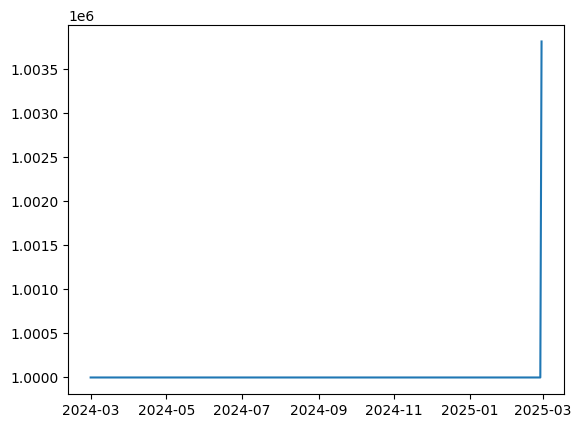

In [220]:
#plot stats['_equity_curve']

import matplotlib.pyplot as plt
plt.plot(stats['_equity_curve']['Equity'])
plt.show()


In [221]:
stats['_equity_curve'][stats['_equity_curve']['Equity'] > 1.000000e+06]


Equity  DrawdownPct  DrawdownDuration
2025-02-28  1.003808e+06          0.0               NaN

In [222]:
stats['_trades']


Empty DataFrame
Columns: [Size, EntryBar, ExitBar, EntryPrice, ExitPrice, SL, TP, PnL, ReturnPct, EntryTime, ExitTime, Duration, Tag]
Index: []